In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Epigenetic age prediction with AltumAge
https://github.com/rsinghlab/AltumAge

Citation: de Lima, Lucas Paulo, Louis R. Lapierre, and Ritambhara Singh. "AltumAge: A Pan-Tissue DNA-Methylation Epigenetic Clock Based on Deep Learning." bioRxiv (2021).

In [2]:
AltumAge_cpgs = np.array(pd.read_pickle('AltumAge/multi_platform_cpgs.pkl'))
AltumAge = tf.keras.models.load_model('AltumAge/AltumAge.h5')
scaler = pd.read_pickle('AltumAge/scaler.pkl')

In [413]:
# plot here is based on the one seen here: https://horvath.genetics.ucla.edu/html/dnamage/TUTORIAL1.pdf
def plot_epi_chrono(epi, chrono, line=True):
    x = np.array(epi)
    y = np.array(chrono)
    medianAbsDev = np.median(abs(x-y))
    cor = stats.pearsonr(x, y)[0]
    p_val = stats.pearsonr(x, y)[1]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(x,y)
    ax.set(xlabel = 'Epigenetic age',ylabel='Chronological age')
    if line==True:
        plt.plot(x, x + 1, '--c')
    ax.set_title(('MAD={:.2g} correlation={:.2g}, p-val={:.2g}').format(medianAbsDev, cor, p_val))
    plt.show

In [502]:
data_meta = pd.read_csv('data/covidGSE167202_meta.csv')

#### With native (normal-exponential out-of-band) normalization:
(not recommended for AltumAge)

In [428]:
data_norm = pd.read_csv('data/covidGSE167202_original.csv')
temp = data_norm.T
temp.columns = data_norm.iloc[:,0]
data_norm = temp.iloc[1:]
data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge = AltumAge.predict(methylation_data_scaled).flatten()

In [412]:
chrono_age = data_meta['age:ch1']

C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


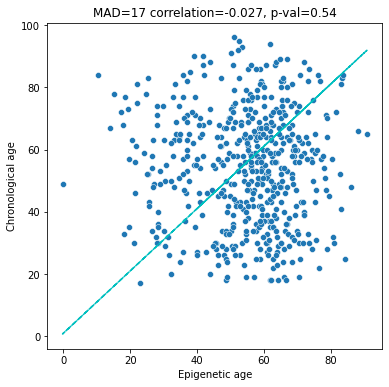

In [430]:
plot_epi_chrono(pred_age_AltumAge, chrono_age)

Not using BMIQ normalization resulted in epigenetic age predictions that don't seem to correlate with chronological age

#### With BMIQ normalization:

In [501]:
data_norm = pd.read_csv('data/covidGSE167202_normalized.csv')

data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge = AltumAge.predict(methylation_data_scaled).flatten()

C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


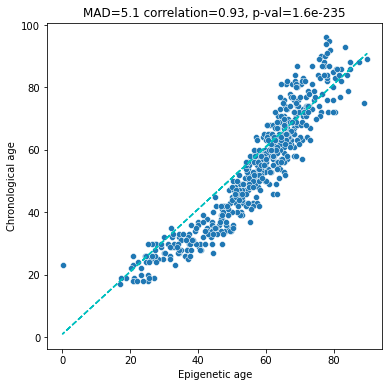

In [503]:
plot_epi_chrono(pred_age_AltumAge, chrono_age)

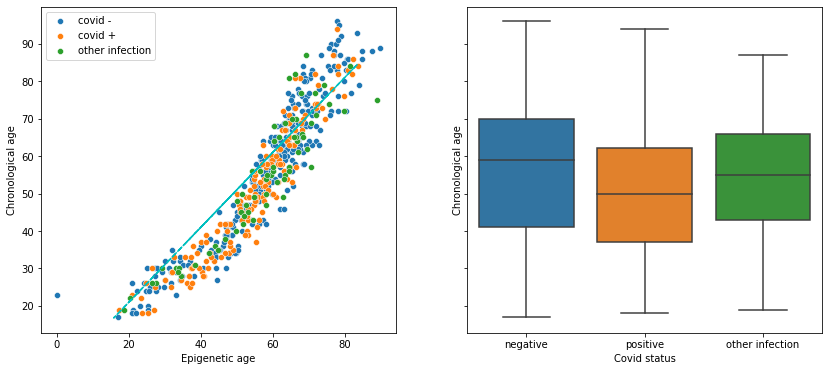

In [606]:
covid_n_age = chrono_age[data_meta['covid_status:ch1'] == 'negative']
covid_n_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'negative']
covid_o_age = chrono_age[data_meta['covid_status:ch1'] == 'other infection']
covid_o_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'other infection']
covid_p_age = chrono_age[data_meta['covid_status:ch1'] == 'positive']
covid_p_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'positive']

fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
                        
sns.scatterplot(ax=axs[0],x=covid_n_altum,y=covid_n_age,label='covid -')
sns.scatterplot(ax=axs[0],x=covid_p_altum,y=covid_p_age,label='covid +')
sns.scatterplot(ax=axs[0],x=covid_o_altum,y=covid_o_age,label='other infection')
axs[0].set(xlabel = 'Epigenetic age',ylabel='Chronological age')
axs[0].plot(x, x + 1, '--c')
sns.boxplot(ax=axs[1],x=data_meta['covid_status:ch1'], y = data_meta['age:ch1'] )
axs[1].set(xlabel = 'Covid status',ylabel='Chronological age')
_ = plt.plot()

The correlation between epigenetic age and chronological age is much better with BMIQ normalization, but epigenetic age predictions don't seem to be uniform across chronological age for both covid negative and covid positive samples in this dataset. Especially since the chronological age distribution of covid negative and positive is not identical and the covid positive set appears to have proportionately more young samples than the covid negative set, this may cause some issues with comparing epigenetic age acceleration between both sets.

I will use 25 random samples (removed from further analysis) from the covid negative set to fit a curve to adjust epigenetic age predictions across chronological age. This will leave 271 negative samples and 164 positive samples.

In [686]:
data = data_meta.filter(['title','geo_accession',
                        'covid_status:ch1','severity score:ch1','patient_asymptomatic:ch1',
                        'admitted_to_icu:ch1','covid_hosp_days:ch1','discharged_to:ch1','ed_disposition:ch1',
                        'ethnicity:ch1','race:ch1','Sex:ch1',
                        'age:ch1'])
data['altum'] = pred_age_AltumAge

In [687]:
covid_negative_for_polyfit = np.random.choice(data_meta.index[data_meta['covid_status:ch1'] == 'negative'], size=25, replace=False)
covid_polyfit_altum = pred_age_AltumAge[data_meta.index.isin(covid_negative_for_polyfit)]
covid_polyfit_age = data_meta['age:ch1'][data_meta.index.isin(covid_negative_for_polyfit)]

data = data.drop(index=covid_negative_for_polyfit)

z = np.polyfit(x=covid_polyfit_altum, 
               y=covid_polyfit_age,deg=4)
p = np.poly1d(z)
adjusted_altum_preds = p(data['altum'])

data['adjusted_altum'] = adjusted_altum_preds
diffs = adjusted_altum_preds - data['age:ch1']
data['diffs'] = diffs

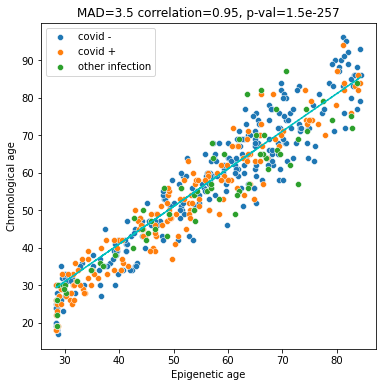

In [5]:
covid_n_age = data['age:ch1'][data['covid_status:ch1'] == 'negative']
covid_n_altum = data['adjusted_altum'][data['covid_status:ch1'] == 'negative']
covid_o_age = data['age:ch1'][data['covid_status:ch1'] == 'other infection']
covid_o_altum = data['adjusted_altum'][data['covid_status:ch1'] == 'other infection']
covid_p_age = data['age:ch1'][data['covid_status:ch1'] == 'positive']
covid_p_altum = data['adjusted_altum'][data['covid_status:ch1'] == 'positive']

x = data['adjusted_altum']
y = data['age:ch1']

medianAbsDev = np.median(abs(x-y))
cor = stats.pearsonr(x,y)[0]
p_val = stats.pearsonr(x,y)[1]

fig, axs = plt.subplots(figsize=(6,6), sharey=True)
                        
sns.scatterplot(x=covid_n_altum,y=covid_n_age,label='covid -')
sns.scatterplot(x=covid_p_altum,y=covid_p_age,label='covid +')
sns.scatterplot(x=covid_o_altum,y=covid_o_age,label='other infection')
axs.set(xlabel = 'Epigenetic age',ylabel='Chronological age')
axs.set_title(('MAD={:.2g} correlation={:.2g}, p-val={:.2g}').format(medianAbsDev, cor, p_val))
axs.plot(x, x + 1, '--c')
_ = plt.plot()

#### Grouping race/ethnicity and saving meta data file with AltumAge epigenetic age:

In [718]:
# grouping ethnicity and race columns
ethnicity_and_race = ((np.where(data['race:ch1'].isna(),'',data['race:ch1'])) + 
                     ((np.where((data['ethnicity:ch1'] != 'Not Hispanic or Latino') & (data['ethnicity:ch1'].notna()), 
                       ' ' + data['ethnicity:ch1'], ''))))
ethnicity_and_race[ethnicity_and_race == ''] = np.nan
# grouping "other hispanic or latino" as just "hispanic or latino" - please reach out to me if this doesn't seem right
ethnicity_and_race[(ethnicity_and_race == ' Hispanic or Latino') | (ethnicity_and_race == 'Other Hispanic or Latino')] = 'Hispanic or Latino'
# there are only 1 or 2 for each group of AmericanIndianorAlaskanNative, NativeHawaiianorPacificIslander, 
# and NativeHawaiianorPacificIslander Hispanic or Latino in this dataset, which is unfortunately too small for any
# statistical effect, so grouping them with "other"
ethnicity_and_race[(ethnicity_and_race == 'AmericanIndianorAlaskanNative') | 
                   (ethnicity_and_race == 'NativeHawaiianorPacificIslander')|
                   (ethnicity_and_race == 'NativeHawaiianorPacificIslander Hispanic or Latino')] = 'Other'

data['diffs'] = diffs
data['ethnicity_and_race'] = ethnicity_and_race

In [723]:
np.unique(data['Sex:ch1'].tolist(), return_counts=True)

(array(['Female', 'Male'], dtype='<U6'), array([241, 259], dtype=int64))

In [724]:
np.unique(data['ethnicity_and_race'].tolist(), return_counts=True)

(array(['Asian', 'BlackorAA', 'Hispanic or Latino', 'Other', 'White',
        'White Hispanic or Latino', 'nan'], dtype='<U24'),
 array([ 18,  87, 121,  12, 230,  27,   5], dtype=int64))

In [725]:
data.to_csv('data_with_epi_age.csv', index=False)

In [875]:
data.head()

,title,geo_accession,covid_status:ch1,severity score:ch1,patient_asymptomatic:ch1,admitted_to_icu:ch1,covid_hosp_days:ch1,discharged_to:ch1,ed_disposition:ch1,ethnicity:ch1,race:ch1,Sex:ch1,age:ch1,altum,adjusted_altum,diffs,ethnicity_and_race
0,genomic DNA from peripheral blood SARS-COV-2- 77,GSM5098953,negative,NaN,NaN,No,NaN,Home,Floor Admission,Not Hispanic or Latino,White,Female,27,44.402985,36.671535,9.671535,White
1,genomic DNA from peripheral blood SARS-COV-2- 124,GSM5098954,negative,NaN,NaN,No,NaN,Home,Discharged,Hispanic or Latino,Other,Male,34,48.271767,40.658740,6.658741,Hispanic or Latino
2,genomic DNA from peripheral blood SARS-COV-2+ 155,GSM5098955,positive,2.0,No,No,1.0,Home,Floor Admission,Hispanic or Latino,Other,Female,53,56.823288,51.888863,-1.111137,Hispanic or Latino
3,genomic DNA from peripheral blood SARS-COV-2+ 139,GSM5098956,positive,2.0,No,No,4.0,Home,Floor Admission,Hispanic or Latino,Other,Female,34,47.963432,40.312920,6.312920,Hispanic or Latino
4,genomic DNA from peripheral blood SARS-COV-2- 295,GSM5098957,negative,NaN,NaN,No,NaN,Nursing home or skilled rehab,Floor Admission,Not Hispanic or Latino,BlackorAA,Male,68,68.156620,69.181810,1.181808,BlackorAA


## Some data visualization and stats:

##### Age acceleration and covid status/severity

In [3]:
data = pd.read_csv('data_with_epi_age.csv')

<ipython-input-7-680c2e9dc8f9>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['discharged_to:ch1'][(data_temp['discharged_to:ch1'] != 'Death')] = 'Survival' # making a bit of an assumption


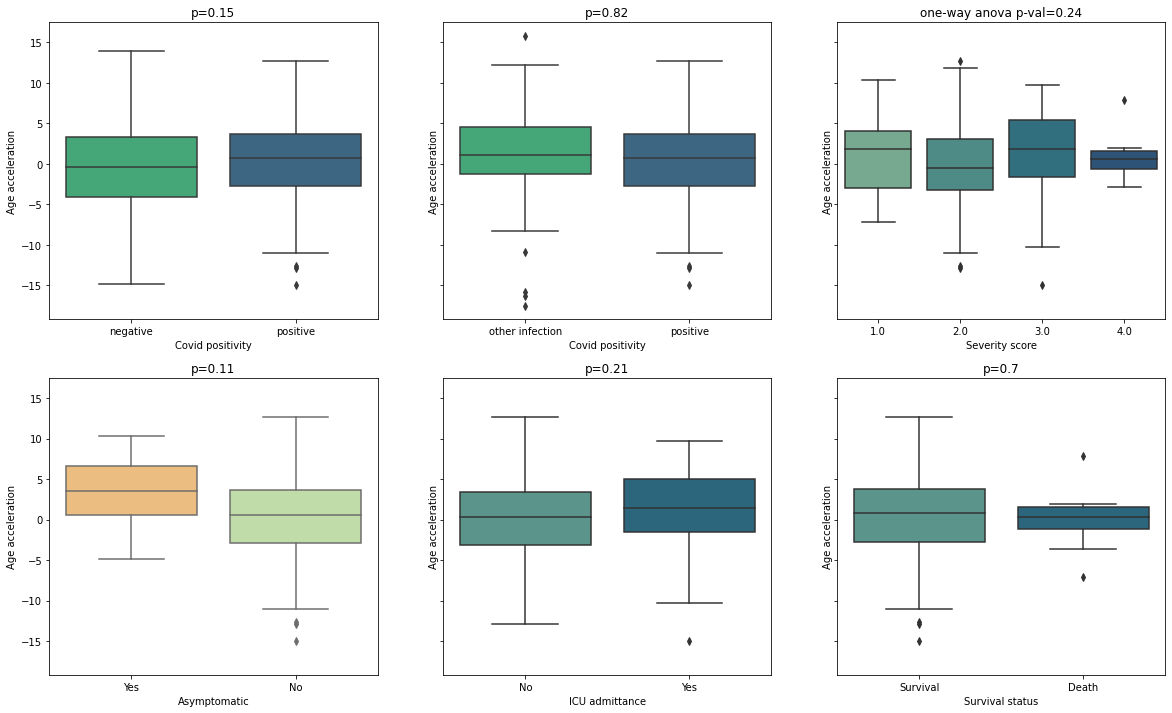

In [7]:
fig, axs = plt.subplots(2,3, figsize=(20, 12), sharey=True)

# plot 1
covid_negative = data.diffs[data['covid_status:ch1'] == 'negative']
covid_positive = data.diffs[data['covid_status:ch1'] == 'positive']
p_val_0 = stats.ttest_ind(covid_negative, covid_positive).pvalue
sns.boxplot(ax=axs[0,0], x=data['covid_status:ch1'][data['covid_status:ch1'] != 'other infection'],
            y=data['diffs'][data['covid_status:ch1'] != 'other infection'],
            palette='viridis_r'
           )
axs[0,0].set(xlabel = 'Covid positivity',ylabel='Age acceleration')
axs[0,0].set_title(('p={:.2g}').format(p_val_0))

# plot 2
covid_negative_other = data.diffs[data['covid_status:ch1'] == 'other infection']
covid_positive = data.diffs[data['covid_status:ch1'] == 'positive']
p_val_1 = stats.ttest_ind(covid_negative_other, covid_positive).pvalue
sns.boxplot(ax=axs[0,1], x=data['covid_status:ch1'][data['covid_status:ch1'] != 'negative'],
            y=data['diffs'][data['covid_status:ch1'] != 'negative'],
            order=['other infection', 'positive'],
            palette='viridis_r'
           )
axs[0,1].set(xlabel = 'Covid positivity', ylabel='Age acceleration')
axs[0,1].set_title(('p={:.2g}').format(p_val_1))

# plot 3
severity = data['severity score:ch1'][data['severity score:ch1'].notna()]
epi_diffs = data['diffs'][data['severity score:ch1'].notna()]
data_stats = data.groupby(by=[data['severity score:ch1']])['diffs']
anova_p_val = stats.f_oneway(*data_stats.apply(list).tolist())[1]
sns.boxplot(ax=axs[0,2], x=severity,y=epi_diffs,palette='crest')
axs[0,2].set(xlabel = 'Severity score', ylabel='Age acceleration')
axs[0,2].set_title(('one-way anova p-val={:.2g}').format(anova_p_val))

# plot 4
asymptomatic = data['diffs'][(data['patient_asymptomatic:ch1'] == 'Yes')& (data['covid_status:ch1'] == 'positive')]
symptomatic = data['diffs'][(data['patient_asymptomatic:ch1'] == 'No')& (data['covid_status:ch1'] == 'positive')]
p_val_3 = stats.ttest_ind(asymptomatic, symptomatic).pvalue
sns.boxplot(ax=axs[1,0], x=data['patient_asymptomatic:ch1'][data['covid_status:ch1'] == 'positive'],
            y=data['diffs'][data['covid_status:ch1'] == 'positive'],
            order = ['Yes','No'],
            palette='Spectral'
           )
axs[1,0].set(xlabel = 'Asymptomatic', ylabel='Age acceleration')
axs[1,0].set_title(('p={:.2g}').format(p_val_3))

# plot 5
not_admitted_to_icu = data['diffs'][(data['admitted_to_icu:ch1'] == 'No')& (data['covid_status:ch1'] == 'positive')]
admitted_to_icu = data['diffs'][(data['admitted_to_icu:ch1'] == 'Yes')& (data['covid_status:ch1'] == 'positive')]
p_val_2 = stats.ttest_ind(not_admitted_to_icu, admitted_to_icu).pvalue
sns.boxplot(ax=axs[1,1], x=data['admitted_to_icu:ch1'][data['covid_status:ch1'] == 'positive'],
            y=data['diffs'][data['covid_status:ch1'] == 'positive'],
            palette='crest'
           )
axs[1,1].set(xlabel = 'ICU admittance',ylabel='Age acceleration')
axs[1,1].set_title(('p={:.2g}').format(p_val_2))

# plot 6
data_temp = data[data['covid_status:ch1'] == 'positive'].copy()
data_temp['discharged_to:ch1'][(data_temp['discharged_to:ch1'] != 'Death')] = 'Survival' # making a bit of an assumption
survived = data_temp['diffs'][(data_temp['discharged_to:ch1'] != 'Death')]
died = data_temp['diffs'][(data_temp['discharged_to:ch1'] == 'Death')]
p_val_4 = stats.ttest_ind(survived, died).pvalue
sns.boxplot(ax=axs[1,2], x=data_temp['discharged_to:ch1'][data_temp['covid_status:ch1'] == 'positive'],
            y=data_temp['diffs'][data_temp['covid_status:ch1'] == 'positive'],
            palette='crest'
           )
axs[1,2].set(xlabel = 'Survival status', ylabel='Age acceleration')
axs[1,2].set_title(('p={:.2g}').format(p_val_4))
_ = plt.plot()

##### Different demographics

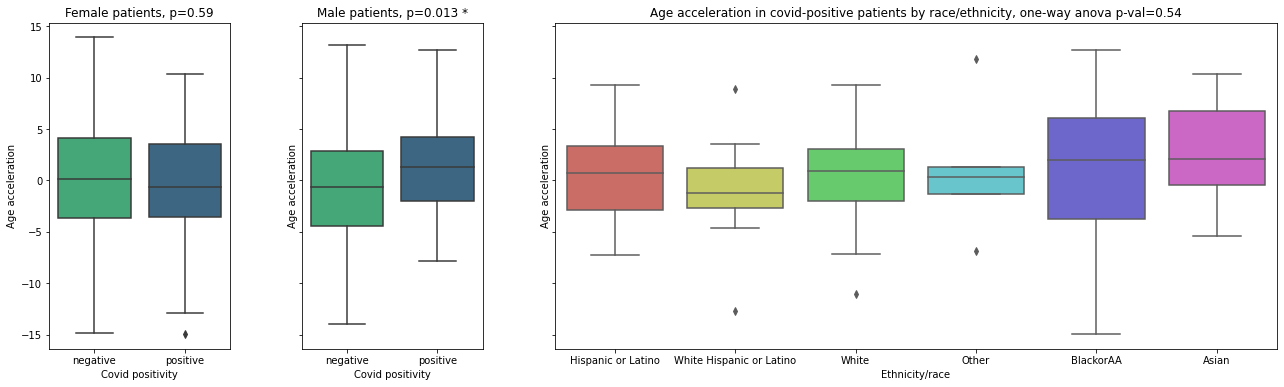

In [8]:
fig, axs = plt.subplots(1, 3, figsize = (22,6), gridspec_kw={'width_ratios': [1, 1, 4]}, sharey=True)

#plot 1
df_f = data[(data['covid_status:ch1'] != 'other infection')& (data['Sex:ch1'] == 'Female')].copy()
p_val_0 = stats.ttest_ind(df_f.diffs[(data['covid_status:ch1'] == 'negative')], 
                          df_f.diffs[(data['covid_status:ch1'] == 'positive')]).pvalue
sns.boxplot(ax=axs[0], x=df_f['covid_status:ch1'], y=df_f['diffs'],palette='viridis_r')
axs[0].set(xlabel = 'Covid positivity',ylabel='Age acceleration')
axs[0].set_title(('Female patients, p={:.2g}').format(p_val_0))

# plot 2
df_m = data[(data['covid_status:ch1'] != 'other infection')& (data['Sex:ch1'] == 'Male')].copy()
p_val_1 = stats.ttest_ind(df_m.diffs[(data['covid_status:ch1'] == 'negative')], 
                          df_m.diffs[(data['covid_status:ch1'] == 'positive')]).pvalue
sns.boxplot(ax=axs[1], x=df_m['covid_status:ch1'], y=df_m['diffs'],palette='viridis_r')
axs[1].set(xlabel = 'Covid positivity', ylabel='Age acceleration')
axs[1].set_title(('Male patients, p={:.2g} *').format(p_val_1))

# plot 3
df = data[['diffs','ethnicity_and_race']][data['covid_status:ch1'] == 'positive']
df_stats = df.groupby(by=['ethnicity_and_race'])['diffs']
anova_p_val = stats.f_oneway(*df_stats.apply(list).tolist())[1]

sns.boxplot(ax=axs[2], x='ethnicity_and_race', y='diffs', data=df, palette='hls')
axs[2].set(xlabel = 'Ethnicity/race', ylabel='Age acceleration')
axs[2].set_title(('Age acceleration in covid-positive patients by race/ethnicity, one-way anova p-val={:.2g}').format(anova_p_val))
_ = plt.plot()

Since male covid patients had a significantly higher epigenetic age acceleration with covid, I wanted to check if they also had a higher covid severity score and chance of dying:

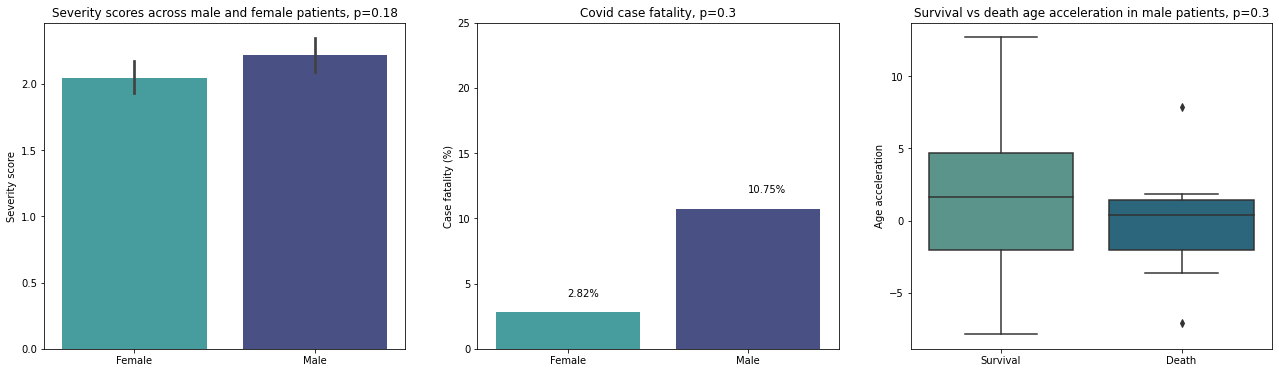

In [10]:
fig, axs = plt.subplots(1,3, figsize = (22,6))

# plot 1
df_s = data[(data['covid_status:ch1'] != 'other infection')& 
            (data['covid_status:ch1'] == 'positive') &
             data['severity score:ch1'].notna()].copy() 
p_val_1 = stats.ttest_ind(df_s['severity score:ch1'][(data['Sex:ch1'] == 'Female')], 
                          df_s['severity score:ch1'][((data['Sex:ch1'] == 'Male'))]).pvalue
sns.barplot(ax=axs[0], x=df_s['Sex:ch1'], y=df_s['severity score:ch1'], ci=85, palette='mako_r')
axs[0].set(xlabel = '', ylabel='Severity score')
axs[0].set_title(('Severity scores across male and female patients, p={:.2g}').format(p_val_1))


# plot 2

df_d = data_temp.copy() # from first plot, subplot 6
f_tot = len(df_d[(df_d['Sex:ch1'] == 'Female')])
f_d = len(df_d[(df_d['Sex:ch1'] == 'Female') & (df_d['discharged_to:ch1'] == 'Death')])
death_p_f = (f_d / f_tot)*100
m_tot = len(df_d[(df_d['Sex:ch1'] == 'Male')])
m_d = len(df_d[(df_d['Sex:ch1'] == 'Male') & (df_d['discharged_to:ch1'] == 'Death')])
death_p_m = (m_d / m_tot)*100
fatality = pd.DataFrame(columns=['Case fatality (%)'],data=[death_p_f,death_p_m],index=['Female','Male'])
fatality['Sex'] = ['Female', 'Male']


sns.barplot(ax=axs[1], x='Sex', y='Case fatality (%)', data=fatality , ci=85, palette='mako_r')
axs[1].set(xlabel = '')
axs[1].set_title(('Covid case fatality, p={:.2g}').format(p_val_2))
axs[1].text(0,4, (str(np.round(death_p_f,2)) + '%'))
axs[1].text(1,12, (str(np.round(death_p_m,2)) + '%'))
axs[1].set(ylim=(0, 25))



# plot 3
df_d = data_temp[(data_temp['Sex:ch1'] == 'Male')].copy()
survived = df_d['diffs'][(df_d['discharged_to:ch1'] != 'Death')]
died = df_d['diffs'][(df_d['discharged_to:ch1'] == 'Death')]
p_val_2 = stats.ttest_ind(survived, died).pvalue
sns.boxplot(ax=axs[2], x=df_d['discharged_to:ch1'][df_d['covid_status:ch1'] == 'positive'],
            y=df_d['diffs'][df_d['covid_status:ch1'] == 'positive'],
            order = ['Survival','Death'],
            palette='crest'
           )
axs[2].set(xlabel = '', ylabel='Age acceleration')
axs[2].set_title(('Survival vs death age acceleration in male patients, p={:.2g}').format(p_val_2))

_ = plt.plot()

Verifying that age distributions are similar across male and female patients:

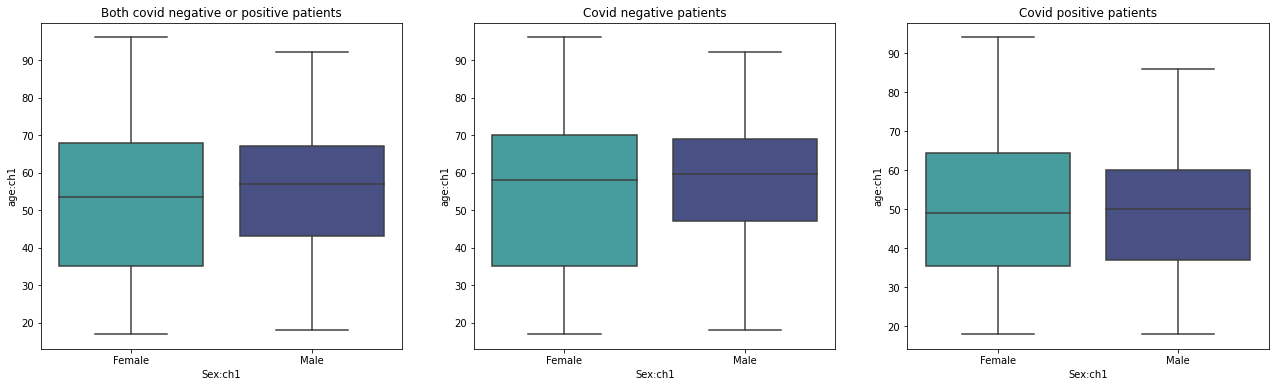

In [1111]:
fig, axs = plt.subplots(1,3, figsize = (22,6))

sns.boxplot(ax=axs[0], x=data['Sex:ch1'][(data['covid_status:ch1'] != 'other infection')], 
            y = data['age:ch1'][(data['covid_status:ch1']!= 'other infections')],
            palette='mako_r'
           )
axs[0].set_title('Both covid negative or positive patients')

sns.boxplot(ax=axs[1], x=data['Sex:ch1'][(data['covid_status:ch1'] == 'negative')], 
            y = data['age:ch1'][(data['covid_status:ch1'] == 'negative')],
            palette='mako_r'
           )
axs[1].set_title('Covid negative patients')

sns.boxplot(ax=axs[2], x=data['Sex:ch1'][(data['covid_status:ch1'] == 'positive')], 
            y = data['age:ch1'][(data['covid_status:ch1'] == 'positive')],
            palette='mako_r'
           )
axs[2].set_title('Covid positive patients')
_ = plt.plot()